In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
forecasting = 20

In [4]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [5]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

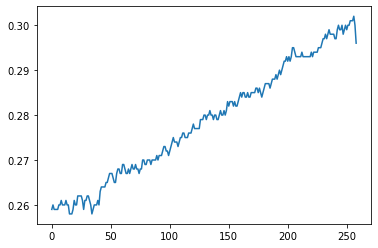

In [6]:
df.plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [8]:
train = df_scaled

In [9]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [11]:
x_train.shape

(191, 20, 1)

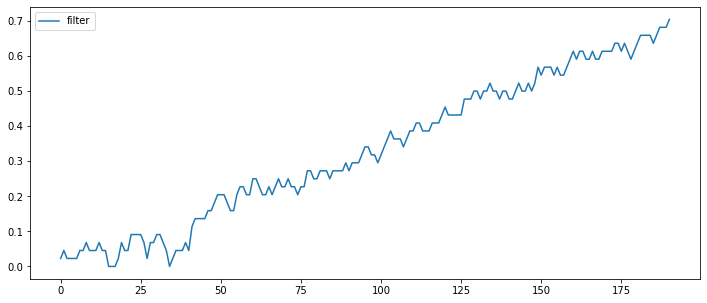

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

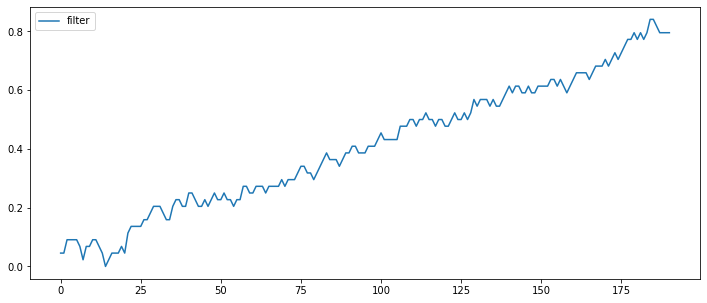

In [13]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [14]:
OUT_STEPS = 20

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(OUT_STEPS))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=100, 
                    batch_size=1)

Epoch 1/100
191/191 [==============================] - 1s 3ms/step - loss: 0.0640 - mean_absolute_error: 0.1681
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0264
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 7.4441e-04 - mean_absolute_error: 0.0214
Epoch 4/100
191/191 [==============================] - 1s 3ms/step - loss: 7.4358e-04 - mean_absolute_error: 0.0214
Epoch 5/100
191/191 [==============================] - 1s 3ms/step - loss: 7.3479e-04 - mean_absolute_error: 0.0214
Epoch 6/100
191/191 [==============================] - 1s 3ms/step - loss: 7.2531e-04 - mean_absolute_error: 0.0214
Epoch 7/100
191/191 [==============================] - 1s 3ms/step - loss: 6.4507e-04 - mean_absolute_error: 0.0203
Epoch 8/100
191/191 [==============================] - 1s 3ms/step - loss: 7.1607e-04 - mean_absolute_error: 0.0215
Epoch 9/100
191/191 [==============================] - 1s 3ms/step - loss: 6.235

191/191 [==============================] - 1s 3ms/step - loss: 4.6329e-04 - mean_absolute_error: 0.0173A: 0s - loss: 4.6387e-04 - mean_absolute_error: 0.01
Epoch 70/100
191/191 [==============================] - 1s 3ms/step - loss: 5.0404e-04 - mean_absolute_error: 0.0180
Epoch 71/100
191/191 [==============================] - 1s 3ms/step - loss: 4.8969e-04 - mean_absolute_error: 0.0175
Epoch 72/100
191/191 [==============================] - 1s 3ms/step - loss: 4.8916e-04 - mean_absolute_error: 0.0175
Epoch 73/100
191/191 [==============================] - 1s 3ms/step - loss: 4.7422e-04 - mean_absolute_error: 0.0175
Epoch 74/100
191/191 [==============================] - 1s 3ms/step - loss: 4.0827e-04 - mean_absolute_error: 0.0163
Epoch 75/100
191/191 [==============================] - 1s 3ms/step - loss: 4.3193e-04 - mean_absolute_error: 0.0166
Epoch 76/100
191/191 [==============================] - 1s 3ms/step - loss: 4.9903e-04 - mean_absolute_error: 0.0179
Epoch 77/100
191/191 [===

num 0 7.947002465908418 actual 0.6190476190476186 prediction 0.66824335
num 1 0.7711112499237955 actual 0.6666666666666661 prediction 0.6718074
num 2 3.5708236694334907 actual 0.7142857142857135 prediction 0.68877983
num 3 11.789494752884009 actual 0.7619047619047628 prediction 0.67208004
num 4 5.955649614334006 actual 0.7142857142857135 prediction 0.67174536
num 5 1.7488837242127366 actual 0.6666666666666661 prediction 0.6783259
num 6 3.968697786331269 actual 0.6666666666666661 prediction 0.69312465
num 7 3.4778267145157775 actual 0.6666666666666661 prediction 0.6898522
num 8 1.2736332416533371 actual 0.7142857142857135 prediction 0.70518833
num 9 0.6089866161347508 actual 0.7142857142857135 prediction 0.7186356
num 10 0.6123578548432469 actual 0.7142857142857135 prediction 0.7186597
num 11 10.853776335716345 actual 0.6666666666666661 prediction 0.7390252
num 12 4.114924669265858 actual 0.7142857142857135 prediction 0.74367803
num 13 0.18709935247886977 actual 0.7619047619047628 predi

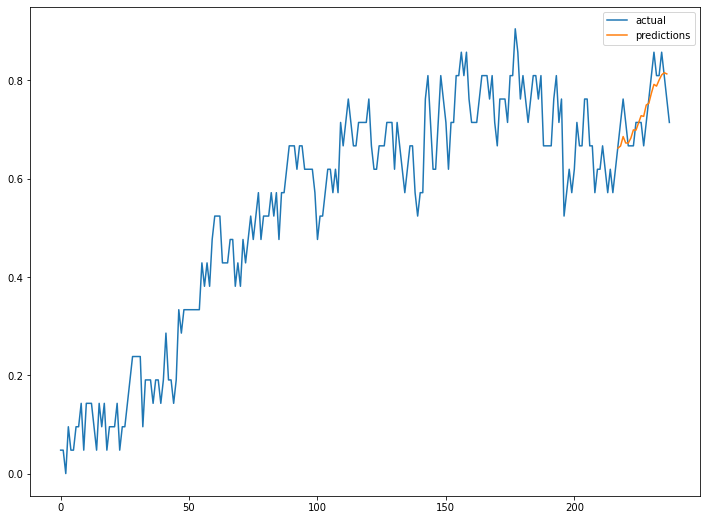

In [17]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.229366759864632 actual 0.8006535947712417 prediction 0.7347649
num 1 8.894544166903342 actual 0.8104575163398693 prediction 0.738371
num 2 6.5782166389097645 actual 0.8137254901960784 prediction 0.76019686
num 3 7.087478065490721 actual 0.8169934640522876 prediction 0.75908923
num 4 6.4280061244964575 actual 0.8169934640522876 prediction 0.7644771
num 5 4.821629305759746 actual 0.8202614379084967 prediction 0.7807115
num 6 3.527155129805849 actual 0.826797385620915 prediction 0.79763496
num 7 4.1842155624180934 actual 0.8366013071895424 prediction 0.8015961
num 8 4.010509708213056 actual 0.8464052287581698 prediction 0.81246006
num 9 2.1953656755644535 actual 0.8529411764705881 prediction 0.834216
num 10 3.905663517491427 actual 0.8594771241830064 prediction 0.82590884
num 11 1.7194275151599332 actual 0.8627450980392155 prediction 0.8479108
num 12 1.9282937949558259 actual 0.8660130718954246 prediction 0.8493138
num 13 0.15346495610360886 actual 0.8660130718954246 prediction 0.

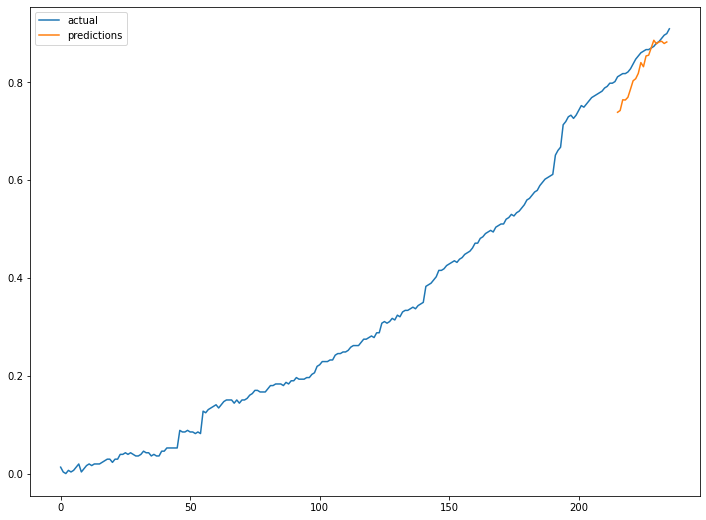

In [18]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

214
(235, 20, 1)
num 0 1.0272238935743154 actual 0.6762402088772845 prediction 0.6831867
num 1 0.42607086625964585 actual 0.6892950391644908 prediction 0.68635815
num 2 1.1554938800326262 actual 0.6971279373368144 prediction 0.7051832
num 3 1.0785906731417412 actual 0.702349869451697 prediction 0.6947744
num 4 1.5685925184580494 actual 0.7075718015665795 prediction 0.6964729
num 5 1.233144637441986 actual 0.7154046997389034 prediction 0.7065827
num 6 0.9412074388141668 actual 0.7284595300261096 prediction 0.7216032
num 7 2.568278443265723 actual 0.7389033942558747 prediction 0.7199263
num 8 2.3319020711586265 actual 0.7493472584856395 prediction 0.7318732
num 9 0.9329645072712466 actual 0.7545691906005221 prediction 0.7475293
num 10 3.0831146158862768 actual 0.7650130548302871 prediction 0.7414268
num 11 0.7896126330304386 actual 0.7676240208877285 prediction 0.76156276
num 12 0.5750628150239361 actual 0.7676240208877285 prediction 0.7632097
num 13 0.28845233805229015 actual 0.77806788

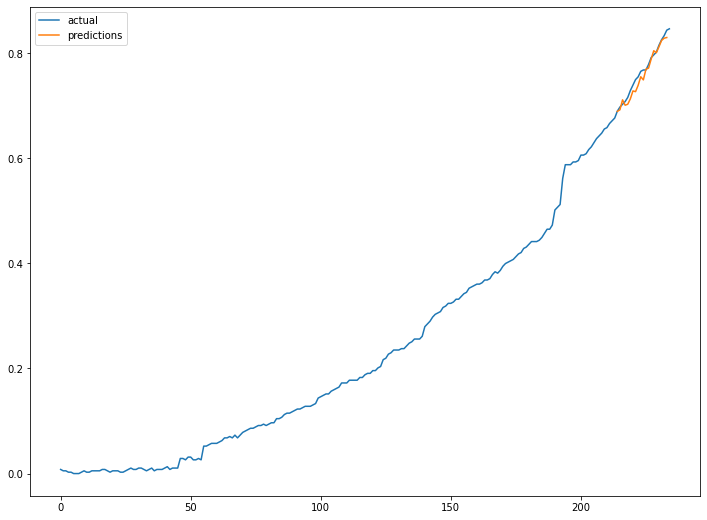

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

print(plot_len)
print(train_feature2.shape)

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.9119720458983656 actual 0.7916666666666661 prediction 0.7606969
num 1 3.0329603897897095 actual 0.7916666666666661 prediction 0.76765573
num 2 0.4746763329757639 actual 0.7916666666666661 prediction 0.7954245
num 3 7.786957422892253 actual 0.75 prediction 0.8084022
num 4 3.2007493470845243 actual 0.7916666666666661 prediction 0.81700593
num 5 12.731329600016275 actual 0.75 prediction 0.845485
num 6 4.028990268707202 actual 0.8333333333333339 prediction 0.86690825
num 7 5.5502247810363015 actual 0.8333333333333339 prediction 0.8795852
num 8 3.1697251579977626 actual 0.9166666666666661 prediction 0.88761085
num 9 4.356214274530885 actual 0.9583333333333339 prediction 0.9165863
num 10 5.783808749655077 actual 0.9583333333333339 prediction 0.90290517
num 11 2.8592959694241005 actual 0.9583333333333339 prediction 0.93093175
num 12 2.946905467821264 actual 0.9583333333333339 prediction 0.93009216
num 13 1.3935130575429449 actual 0.9583333333333339 prediction 0.94497883
num 14 4.71846

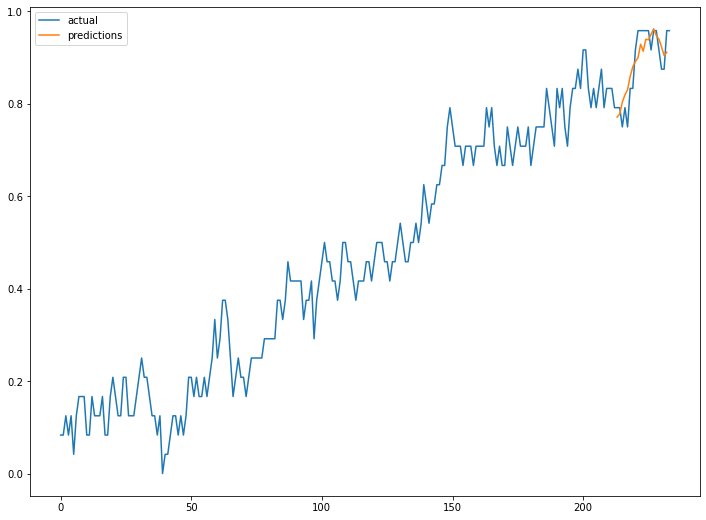

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 10.924361379523013 actual 0.8482142857142856 prediction 0.7555523
num 1 11.374626557032228 actual 0.8571428571428568 prediction 0.75964606
num 2 7.733880093223157 actual 0.8482142857142856 prediction 0.7826144
num 3 7.7319699432213 actual 0.8526785714285712 prediction 0.7867497
num 4 8.312238122999034 actual 0.8660714285714284 prediction 0.7940815
num 5 7.0071629115513385 actual 0.875 prediction 0.8136873
num 6 5.449246634081522 actual 0.8794642857142856 prediction 0.8315401
num 7 5.6712212874062295 actual 0.8883928571428568 prediction 0.83801013
num 8 4.037614302201677 actual 0.8839285714285712 prediction 0.84823895
num 9 1.7647441308102596 actual 0.8883928571428568 prediction 0.872715
num 10 2.3806128839049396 actual 0.8839285714285712 prediction 0.86288565
num 11 0.818791389465325 actual 0.8928571428571428 prediction 0.8855465
num 12 1.6975544466830372 actual 0.901785714285714 prediction 0.8864774
num 13 0.6251433800006735 actual 0.90625 prediction 0.90058464
num 14 0.99034802

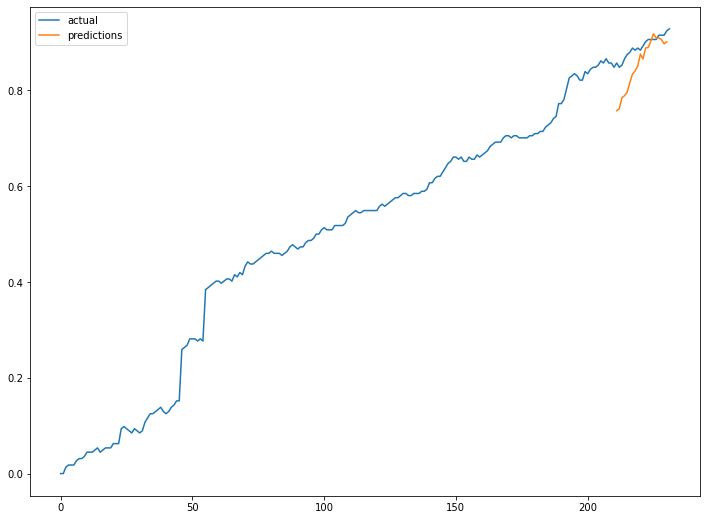

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 23.317011664895578 actual 0.8500000000000014 prediction 0.6518054
num 1 18.243907392025065 actual 0.8000000000000007 prediction 0.65404874
num 2 10.311166445414226 actual 0.75 prediction 0.67266625
num 3 11.30398114522298 actual 0.75 prediction 0.66522014
num 4 11.090787251790363 actual 0.75 prediction 0.6668191
num 5 9.718235333760578 actual 0.75 prediction 0.67711323
num 6 1.2701511383058144 actual 0.7000000000000011 prediction 0.69110894
num 7 2.00073378426703 actual 0.7000000000000011 prediction 0.68599486
num 8 6.87695099757262 actual 0.6500000000000004 prediction 0.6947002
num 9 0.5681582859582732 actual 0.7000000000000011 prediction 0.7039771
num 10 7.5865983963012695 actual 0.75 prediction 0.6931005
num 11 5.370338757832846 actual 0.75 prediction 0.70972246
num 12 0.6266048976351704 actual 0.7000000000000011 prediction 0.70438623
num 13 2.6814324515204913 actual 0.7000000000000011 prediction 0.71877
num 14 9.042544662952503 actual 0.8000000000000007 prediction 0.72765964


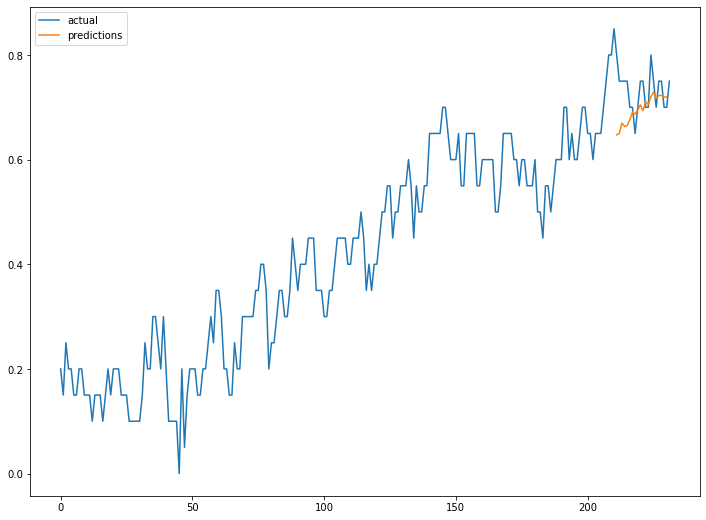

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 11.6366982460021 actual 0.8421052631578938 prediction 0.744112
num 1 13.89463959318217 actual 0.8684210526315788 prediction 0.7477571
num 2 8.829995989799398 actual 0.8421052631578938 prediction 0.7677474
num 3 12.23254492788602 actual 0.8684210526315788 prediction 0.76219106
num 4 11.691222407601078 actual 0.8684210526315788 prediction 0.766892
num 5 7.369418814778225 actual 0.8421052631578938 prediction 0.780047
num 6 2.4337041762566387 actual 0.8157894736842097 prediction 0.7959356
num 7 2.023334272446075 actual 0.8157894736842097 prediction 0.7992833
num 8 3.5492457449435117 actual 0.8421052631578938 prediction 0.8122169
num 9 0.8909560739992949 actual 0.8421052631578938 prediction 0.8346025
num 10 4.393193577275111 actual 0.8684210526315788 prediction 0.83026963
num 11 1.1178586632014442 actual 0.8421052631578938 prediction 0.8515188
num 12 4.286016786799676 actual 0.8947368421052628 prediction 0.8563883
num 13 0.4875287865147663 actual 0.8684210526315788 prediction 0.872654

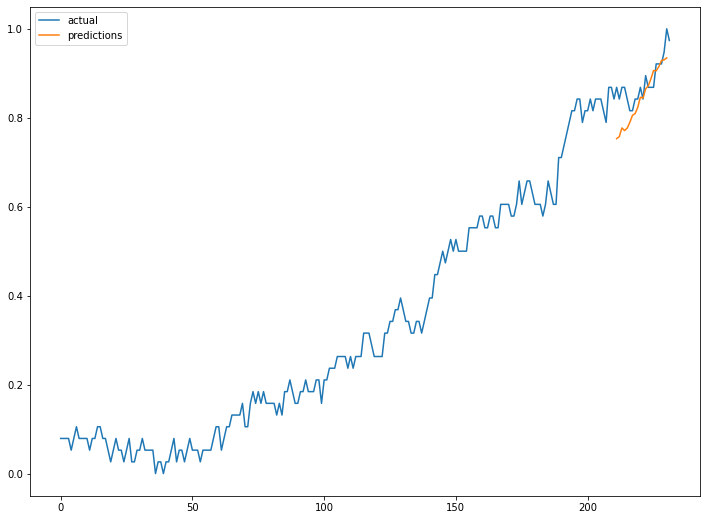

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 7.6284211874009165 actual 0.76923076923077 prediction 0.7105506
num 1 2.4276476157340277 actual 0.7307692307692317 prediction 0.7130287
num 2 0.1309250530442383 actual 0.7307692307692317 prediction 0.731726
num 3 0.7444469552292365 actual 0.7307692307692317 prediction 0.72532904
num 4 5.373797151777583 actual 0.6923076923076916 prediction 0.7295109
num 5 3.6223232746125293 actual 0.76923076923077 prediction 0.74136674
num 6 6.342655136471782 actual 0.8076923076923084 prediction 0.75646317
num 7 6.452508199782677 actual 0.8076923076923084 prediction 0.7555759
num 8 9.256319024346151 actual 0.8461538461538467 prediction 0.76783115
num 9 2.7153787158785234 actual 0.8076923076923084 prediction 0.7857604
num 10 1.2107521295546406 actual 0.76923076923077 prediction 0.77854425
num 11 3.7450957298277703 actual 0.76923076923077 prediction 0.7980392
num 12 3.9526963233946644 actual 0.76923076923077 prediction 0.7996361
num 13 0.902673176356639 actual 0.8076923076923084 prediction 0.8149831

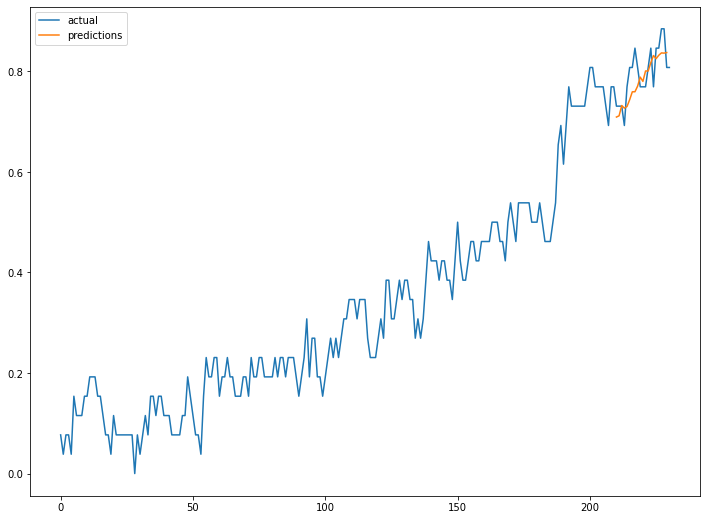

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.5435634454091085 actual 0.7389162561576352 prediction 0.7053431
num 1 5.39934631240995 actual 0.7487684729064039 prediction 0.70833987
num 2 3.336284947551107 actual 0.7536945812807878 prediction 0.7285492
num 3 4.810615561225165 actual 0.7586206896551722 prediction 0.72212636
num 4 5.608067489587337 actual 0.7684729064039408 prediction 0.7253764
num 5 4.574845930573294 actual 0.7733990147783252 prediction 0.7380172
num 6 3.1645936301991555 actual 0.7783251231527091 prediction 0.7536943
num 7 3.73045798367672 actual 0.7832512315270934 prediction 0.7540324
num 8 2.9038133472204115 actual 0.7881773399014778 prediction 0.76529014
num 9 1.2632121210512945 actual 0.7931034482758621 prediction 0.78308487
num 10 2.8060517193358248 actual 0.798029556650246 prediction 0.77563643
num 11 0.21958229718381062 actual 0.798029556650246 prediction 0.7962772
num 12 1.3198607215067115 actual 0.8078817733990147 prediction 0.79721886
num 13 1.106388661675797 actual 0.8226600985221673 prediction 0.

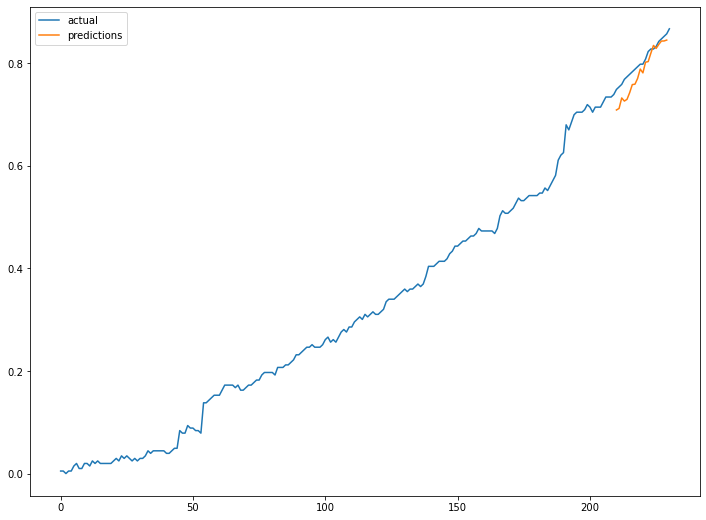

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()